In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2

%matplotlib inline

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

C:\Users\user\Anaconda3\envs\networks\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4634630601500064563
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6705216225
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14514268848476713149
physical_device_desc: "device: 0, name: Quadro P4000, pci bus id: 0000:65:00.0, compute capability: 6.1"
]


In [3]:
train_x = pd.read_csv('input/train_x.csv', index_col=0, header=None)
train_y = pd.read_csv('input/train_y.csv', index_col=0)
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)

In [4]:
test_x.shape

(4800, 3072)

In [5]:
import matplotlib
matplotlib.use("Agg")
 
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
# from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os
# from keras.utils import np_utils
import gc 

import pandas as pd 
import matplotlib.pyplot as plt 
import os
from keras.utils import np_utils
import cv2

%matplotlib inline

Using TensorFlow backend.


In [6]:
EPOCHS = 100
INIT_LR = 1e-3
IMAGE_DIMS = (32 , 32 , 3)
BATCH_SIZE = 520

In [7]:
mappping_type = {'Bird': 0, 'Airplane': 1}
train_y_bin = train_y.replace({"target": mappping_type})

In [8]:
d1 = [[np.array(x)] for x in train_x.values]
d = {'map': d1, 'target': train_y_bin.target}

In [9]:
df = pd.DataFrame(data=d)

In [10]:
df.map.shape

(7200,)

In [11]:
df.head()

,map,target
0,"[[4, 20, 18, 4, 16, 15, 2, 11, 9, 2, 6, 5, 1, ...",0
1,"[[109, 155, 233, 109, 155, 231, 110, 156, 232,...",1
2,"[[156, 172, 195, 158, 174, 197, 158, 174, 197,...",1
3,"[[115, 108, 52, 97, 100, 79, 86, 107, 98, 79, ...",1
4,"[[167, 205, 221, 160, 198, 213, 161, 198, 214,...",1


In [12]:
def make_image_gen_cat(in_df, batch_size=BATCH_SIZE):
    all_batches = in_df.sample(frac=1)
    out_map = []
    out_class = []
    while True:
        for index, row in in_df.iterrows():
#             out_map += [np.expand_dims(row.waferMap, -1)]
#             out_map += [row.map]
            out_map += [pd.Series(row).values[0][0]]
#             print(pd.Series(row).values[0][0])
            out_class += [row.target]
            if len(out_map) >= batch_size:
                out_map = np.array(out_map)
                out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
                yield np.stack(out_map, 0), np.array(np_utils.to_categorical(out_class, num_classes=2))
                out_map = []
                out_class = []

In [13]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)
train_df.shape[0], valid_df.shape[0]

(5760, 1440)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15,  
                  horizontal_flip = True, 
                  vertical_flip = True)

image_gen = ImageDataGenerator(**dg_args)
label_gen = ImageDataGenerator()

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        # keep the seeds syncronized otherwise the augmentation 
        # to the images is different from the masks
        g_x = image_gen.flow(in_x, 
                             batch_size = in_x.shape[0])

        yield next(g_x), in_y

In [15]:
train_gen = make_image_gen_cat(train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape)
print('y', train_y.shape)
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)

gc.collect()

x (520, 32, 32, 3)
y (520, 2)


27

(520, 32, 32, 3) (520, 2)
[0. 1.]
Wall time: 108 ms


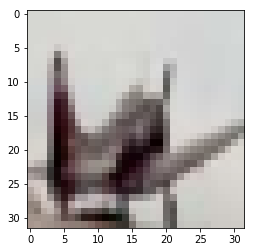

In [16]:
%%time
valid_x, valid_y = next(make_image_gen_cat(train_df))
print(valid_x.shape, valid_y.shape)

n = 16
plt.imshow(valid_x[n,:,:])
print(valid_y[n])

In [17]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.utils import np_utils

In [18]:
class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes, finalAct="softmax"):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same", 
                         input_shape=(IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(48, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(48, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(80, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.3))

                # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(8, 8)))
        model.add(Dropout(0.4))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        model.add(Dense(classes))
        
        model.add(Activation(finalAct))

        # return the constructed network architecture
        return model

In [19]:
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
                            depth=IMAGE_DIMS[2], classes=2, 
                            finalAct="sigmoid")
 
# initialize the optimizer
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
__________

In [21]:
from keras.callbacks import Callback
class TestCallback(Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, dice_coef, acc, _ = self.model.evaluate(x, y, verbose=0)
        print('\n - Testing loss: {:.4f} - dice_coef: {:.4f} - acc: {:.4f}\n'.format(loss, dice_coef, acc))

In [22]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path="C:\\Users\\user\\Python_Code\\Kaggle\\Plane&Bird\\strong_weights_2.h5"
# weight_path = ''
checkpoint = ModelCheckpoint(weight_path, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_acc', factor=0.33,
                                   patience=3, verbose=1, mode='max',
                                   min_delta=0.0001, cooldown=0, min_lr=1e-6)

early = EarlyStopping(monitor="val_acc", mode="max", verbose=2, 
                      patience=10)



callbacks_list = [checkpoint, reduceLROnPlat]

gc.collect()

0

In [28]:
from keras import metrics
from keras import backend as K

model.compile(optimizer=Adam(1e-3, decay=1e-6), 
              loss="categorical_crossentropy",
              metrics=["accuracy", 
                      metrics.categorical_accuracy])

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
reset_weights(model)

In [29]:
BATCH_SIZE = 1000
gen_train_cat = make_image_gen_cat(train_df)
gen_valid_cat = make_image_gen_cat(valid_df)

aug_gen_cat = create_aug_gen(make_image_gen_cat(train_df))


net = model.fit_generator(gen_train_cat,
                          steps_per_epoch = 500,
                          epochs = 50,
                          validation_data = gen_valid_cat,
                          validation_steps = 300,
                          callbacks = callbacks_list,
                          workers=1, 
                          verbose = 1)

Epoch 1/50
500/500 [==============================] - 159s 319ms/step - loss: 0.1568 - acc: 0.9347 - categorical_accuracy: 0.9347 - val_loss: 0.5558 - val_acc: 0.9021 - val_categorical_accuracy: 0.9021

Epoch 00001: val_acc improved from 0.49174 to 0.90206, saving model to C:\Users\user\Python_Code\Kaggle\Plane&Bird\strong_weights_2.h5
Epoch 2/50
500/500 [==============================] - 157s 314ms/step - loss: 0.0218 - acc: 0.9923 - categorical_accuracy: 0.9923 - val_loss: 0.5637 - val_acc: 0.8931 - val_categorical_accuracy: 0.8931

Epoch 00002: val_acc did not improve from 0.90206
Epoch 3/50
500/500 [==============================] - 158s 315ms/step - loss: 0.0110 - acc: 0.9963 - categorical_accuracy: 0.9963 - val_loss: 0.8181 - val_acc: 0.8715 - val_categorical_accuracy: 0.8715

Epoch 00003: val_acc did not improve from 0.90206
Epoch 4/50
500/500 [==============================] - 157s 314ms/step - loss: 0.0087 - acc: 0.9971 - categorical_accuracy: 0.9971 - val_loss: 0.6107 - val_a

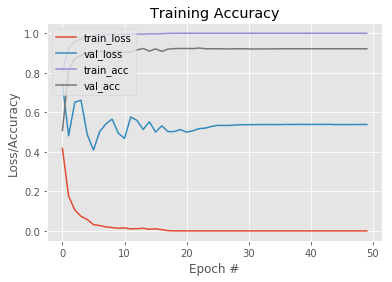

In [49]:

# plot the training loss
plt.style.use("ggplot")
plt.figure()
N = 50
plt.plot(np.arange(0, N), net.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), net.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
# plot the trainingaccuracy
plt.plot(np.arange(0, N), net.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), net.history["val_acc"], label="val_acc")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left");

In [51]:
[2*i for i in range(10)]

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]

In [40]:
test_x = pd.read_csv('input/test_x.csv', index_col=0, header=None)
test_d1 = [[np.array(x)] for x in test_x.values]
test_d1 = {'map': test_d1}
test = pd.DataFrame(data=test_d1)

In [41]:
out_map = []
out_class = []
for index, row in test.iterrows():
    out_map += [pd.Series(row).values[0][0]]

out_map = np.array(out_map)
out_map = out_map.reshape(out_map.shape[0], IMAGE_DIMS[0], IMAGE_DIMS[1], IMAGE_DIMS[2])
out_map = np.stack(out_map, 0)

In [42]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

(4800, 2)
Wall time: 2.07 s


In [43]:
%%time
y_test_pred = model.predict(out_map)

print(y_test_pred.shape)

df = np.array([[i, x.argmax()] for i, x in enumerate(y_test_pred)])
sample = pd.DataFrame(df, columns=['id', 'target'])

mappping_type_inv = {0: 'Bird', 1: 'Airplane'}
sample = sample.replace({'target': mappping_type_inv})

sample.to_csv('output/submit_12.csv', index=False)

(4800, 2)
Wall time: 1.63 s


In [44]:
sample.head()

NameError: name 'sample' is not defined

In [33]:
sample.to_csv('output/submit_12.csv', index=False)

NameError: name 'sample' is not defined